Import useful packages:
- PyRCN for Echo State Networks
- Numpy for matrix processing
- 

In [2]:
import numpy as np
import librosa
import glob
from pyrcn.echo_state_network import ESNRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.model_selection import ParameterGrid
from scipy.signal import find_peaks
import time
from joblib import Parallel, delayed, dump, load

import matplotlib
from matplotlib import pyplot as plt
#Options
params = {'image.cmap' : 'jet',
          'text.usetex' : False,
          'font.size' : 11,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 16,
          'ytick.labelsize' : 16,
          'text.latex.unicode': False,
          }
plt.rcParams.update(params) 
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = False

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import librosa.display
%matplotlib inline

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [7]:
print(glob.glob(r"/home/s2575425/*"))
all_wavs_m = glob.glob(r"/projects/p_transcriber/SpLxDataLondonStudents2008/M/*.wav")
print(len(all_wavs_m))
all_wavs_n = glob.glob(r"/projects/p_transcriber/SpLxDataLondonStudents2008/N/*.wav")
print(len(all_wavs_n))

[]
0
0


We have two directories with WAV files (M and N). After removing several "broken" or "duplicates", the directory "M" contained 24 speakers and the directory "N" 32 speakers, who all read the phonetically balanced "Arthur the Rat" passage in British English.



In [6]:
y, fs = librosa.load(all_wavs_m[0], sr=None, mono=False)
print(y.shape)
print(fs)

IndexError: list index out of range

Visualization

In [4]:
# Define time axis in seconds
t = np.arange(y.shape[1]) / fs

plt.figure(figsize=(6, 1.8))
plt.plot(t, y[0, :], color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.4, 0.4])
plt.tick_params(direction='in')
plt.title("Speech signal")
plt.tight_layout()

plt.figure(figsize=(6, 1.8))
plt.plot(t, y[1, :], color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t[0], t[-1]])
plt.ylim([-1.1, 1.1])
plt.tick_params(direction='in')
plt.title("Lx")
plt.tight_layout()

plt.figure(figsize=(6, 1.8))
plt.plot(t, np.diff(y[1, :], prepend=0), color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.1, 0.2])
plt.tick_params(direction='in')
plt.title("LxDiff")
plt.tight_layout()

NameError: name 'y' is not defined

Resampling to 4kHz

In [5]:
y = librosa.resample(y, orig_sr=fs, target_sr=4000)
print(y.shape)

(2, 512060)


Visualization

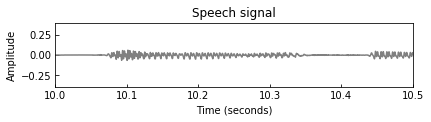

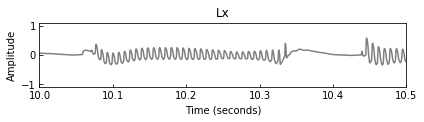

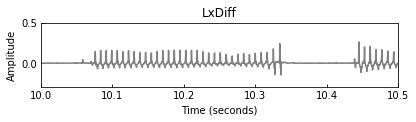

In [6]:
# Define time axis in seconds
t = np.arange(y.shape[1]) / 4000

plt.figure(figsize=(6, 1.8))
plt.plot(t, y[0, :], color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t[40000], t[42000]])
plt.ylim([-0.4, 0.4])
plt.tick_params(direction='in')
plt.title("Speech signal")
plt.tight_layout()

plt.figure(figsize=(6, 1.8))
plt.plot(t, y[1, :], color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t[40000], t[42000]])
plt.ylim([-1.1, 1.1])
plt.tick_params(direction='in')
plt.title("Lx")
plt.tight_layout()

plt.figure(figsize=(6, 1.8))
plt.plot(t, np.diff(y[1, :], prepend=0), color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t[40000], t[42000]])
plt.ylim([-0.3, 0.5])
plt.tick_params(direction='in')
plt.title("LxDiff")
plt.tight_layout()

Function to extract features

In [7]:
def extract_features(filename: str, sr: float = 4000., frame_length: int = 81, target_widening: bool = True):
    s, sr = librosa.load(filename, sr=sr, mono=False)
    X = librosa.util.frame(s[0, :], frame_length=frame_length, hop_length=1).T
    y = librosa.util.frame(binarize_signal(s[1, :], 0.04), frame_length=frame_length, hop_length=1).T
    if target_widening:
        return X, np.convolve(y[:, int(frame_length / 2)], [0.5, 1.0, 0.5], 'same')
    else:
        return X, y[:, int(frame_length / 2)]

Function to binarize the signal (differentiate, Peaks will be 1, remaining part zero)

In [8]:
def binarize_signal(y, thr=0.04):
    y_diff = np.maximum(np.diff(y, prepend=0), thr)
    peaks, _ = find_peaks(y_diff)
    y_bin = np.zeros_like(y_diff, dtype=int)
    y_bin[peaks] = 1
    return y_bin

Define a helper function for MLP training

Train and store MLP Classifiers for various window sizes

In [9]:
def train_mlp(frame_length, file_list):
    print(frame_length)
    X_train = []
    y_train = []
    try:
        load("mlp_" + str(frame_length) + ".joblib")
    except FileNotFoundError:
        for file in file_list[:8]:
            X, y = extract_features(file, sr = 4000., frame_length = frame_length, target_widening = False)
            X_train.append(X)
            y_train.append(y)
        clf = MLPClassifier(hidden_layer_sizes=(12, 10), verbose=True, random_state=1).fit(np.vstack(X_train), np.hstack(y_train))
        dump(clf, "mlp_" + str(frame_length) + ".joblib")

t1 = time.time()
Parallel(n_jobs=-1, verbose=50)(delayed(train_mlp)(frame_length, all_wavs_m) for frame_length in [1, 3, 5, 7, 9, 11, 21, 31, 41, 81])
print("Finished in {0} seconds!".format(time.time() - t1))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    5.5s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    5.5s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.5s finished
Finished in 5.587828636169434 seconds!


ROC plot of MLP results with different window lengths

1
3
5
7
9
11
21
31
41
81


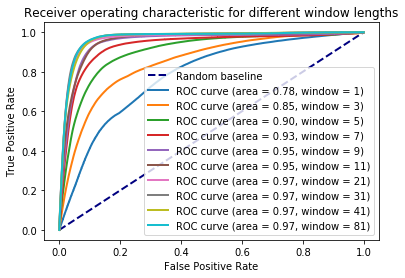

In [10]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random baseline')
for frame_length in [1, 3, 5, 7, 9, 11, 21, 31, 41, 81]:
    print(frame_length)
    X_val = []
    y_val = []
    for file in all_wavs_m[13:]:
        X, y = extract_features(file, sr = 4000., frame_length = frame_length, target_widening=False)
        X_val.append(X)
        y_val.append(y)
    clf = load("mlp_" + str(frame_length) + ".joblib")
    y_pred = clf.predict_proba(X=np.vstack(X_val))
    fpr, tpr, _ = roc_curve(np.hstack(y_val), y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f, window = %d)' % (roc_auc, frame_length))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different window lengths')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
plt.savefig('roc_mlp.pdf')

Extract features for training and hyperparameter optimization

In [11]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []
print("Training files:")
for file in all_wavs_m[:8]:
    print(file)
    X, y = extract_features(file, sr = 4000., frame_length = 1)
    X_train.append(X)
    y_train.append(y)
    print(X_train[-1].shape)
    print(y_train[-1].shape)
print("Test files:")
for file in all_wavs_m[8:13]:
    print(file)
    X, y = extract_features(file, sr = 4000., frame_length = 1)
    X_test.append(X)
    y_test.append(y)
    print(X_test[-1].shape)
    print(y_test[-1].shape)
print("Validation files:")
for file in all_wavs_m[13:]:
    print(file)
    X, y = extract_features(file, sr = 4000., frame_length = 1)
    X_val.append(X)
    y_val.append(y)
    print(X_val[-1].shape)
    print(y_val[-1].shape)

Training files:
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M003.wav
(512060, 1)
(512060,)
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M001.wav
(499003, 1)
(499003,)
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M002.wav
(461372, 1)
(461372,)
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M004.wav
(497464, 1)
(497464,)
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M005.wav
(493812, 1)
(493812,)
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M007.wav
(461947, 1)
(461947,)
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M009.wav
(423548, 1)
(423548,)
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M010.wav
(466556, 1)
(466556,)
Test files:
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M011.wav
(471548, 1)
(471548,)
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M012.wav
(484988, 1)
(484988,)
/projects/p_transcriber/SpLxDataLondonStudents2008/M/M013.wav
(550263, 1)
(550263,)
/projects/p_transcriber/SpLxDataLondonStudents20

Define a basic esn with default hyperparameters.

In [12]:
base_esn = ESNRegressor(k_in = 1, input_scaling = 14.6, spectral_radius = 1.0, bias = 0.0, leakage = 1.0,
                        reservoir_size = 500, k_res = 16, reservoir_activation = 'tanh', teacher_scaling = 1.0,
                        teacher_shift = 0.0, bi_directional = False, solver = 'ridge', beta = 1.75e-10, random_state = 1)

In [13]:
esn = clone(base_esn)
for X, y in zip(X_train, y_train):
    esn.partial_fit(X=X, y=y, update_output_weights=False)
esn.finalize()

/software/generic/JupyterHub/test/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/s2575425/.local/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/s2575425/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


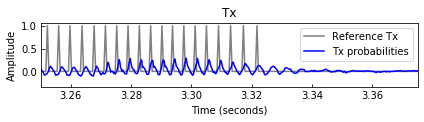

In [14]:
y_pred = esn.predict(X=X_val[0])
t = np.arange(len(y_pred)) / 4000
plt.figure(figsize=(6, 1.8))
plt.plot(t, y_val[0], color='gray', label='Reference Tx')
plt.plot(t, y_pred, color='blue', label='Tx probabilities')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t[13000], t[13500]])
plt.tick_params(direction='in')
plt.title("Tx")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('Tx_example_1_sample.pdf')

Repeat the same without leaky integration - it is strange that the results are better when introducing leakage!

In [15]:
base_esn = ESNRegressor(k_in = 1, input_scaling = 14.6, spectral_radius = 1.0, bias = 0.0, leakage = 0.5,
                        reservoir_size = 500, k_res = 16, reservoir_activation = 'tanh', teacher_scaling = 1.0,
                        teacher_shift = 0.0, bi_directional = False, solver = 'ridge', beta = 1.75e-10, random_state = 1)

In [16]:
esn = clone(base_esn)
for X, y in zip(X_train, y_train):
    esn.partial_fit(X=X, y=y, update_output_weights=False)
esn.finalize()

/software/generic/JupyterHub/test/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/s2575425/.local/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/s2575425/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


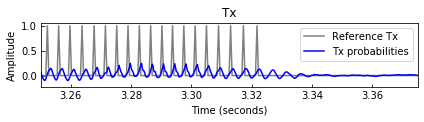

In [17]:
y_pred = esn.predict(X=X_val[0])
t = np.arange(len(y_pred)) / 4000
plt.figure(figsize=(6, 1.8))
plt.plot(t, y_val[0], color='gray', label='Reference Tx')
plt.plot(t, y_pred, color='blue', label='Tx probabilities')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t[13000], t[13500]])
plt.tick_params(direction='in')
plt.title("Tx")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('Tx_example_2_sample.pdf')

/software/generic/JupyterHub/test/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/s2575425/.local/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/s2575425/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


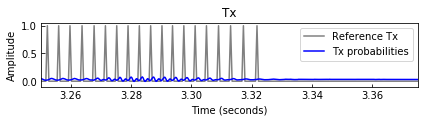

In [18]:
from sklearn.linear_model import RidgeCV
reg = RidgeCV(alphas=(1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0, 5e0, 1e1)).fit(X=np.vstack(X_train), y=np.hstack(y_train))

dump(reg, "ridge_1.joblib")

y_pred = reg.predict(X=X_val[0])
t = np.arange(len(y_pred)) / 4000
plt.figure(figsize=(6, 1.8))
plt.plot(t, y_val[0], color='gray', label='Reference Tx')
plt.plot(t, y_pred, color='blue', label='Tx probabilities')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t[13000], t[13500]])
plt.tick_params(direction='in')
plt.title("Tx")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('Tx_example_2_rr_sample.pdf')